In [57]:
import os

import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

import src.visualization as vs
import src.json_cleaning as jc


In [63]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')
data.shape
data

,country,staff_pick,state,usd_pledged,usd_type,converted_goal,pledge_per_backer,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month,weekday,day_hour
0,US,False,1,802.00,international,200.0,38.19,26.0,4,Rock,music,3888000,351356,December,Wednesday,22
1,US,False,1,2259.00,international,400.0,23.29,9.0,5,Mixed Media,art,1728000,413843,February,Wednesday,16
2,US,True,1,29638.00,international,27224.0,336.80,25.0,9,Photobooks,photography,2595600,769946,November,Tuesday,14
3,IT,False,1,49075.15,international,45461.0,254.28,13.0,5,Footwear,fashion,3625358,314662,October,Saturday,23
4,US,False,0,549.00,domestic,1000.0,27.45,22.0,4,Software,technology,2592000,212500,March,Monday,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168974,US,False,0,135.00,international,5000.0,19.29,23.0,6,Crochet,crafts,2586290,2260,February,Tuesday,19
168975,US,False,1,18608.00,domestic,17486.0,86.55,24.0,3,Children's Books,publishing,2592000,3347824,July,Friday,11
168976,AU,False,0,316.50,domestic,5820.6,28.77,20.0,10,Cookbooks,food,2592000,368044,December,Saturday,9
168977,US,False,0,0.00,international,8000.0,NaN,12.0,4,Childrenswear,fashion,2592000,1254071,August,Friday,21


In [62]:
data2 = pd.read_csv('data/raw/kickstarter.csv')

def drop_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    """Drop duplicate rows, and rows that are duplicated and rows that only differ in usd_type"""

    df = df.query('~(id.duplicated() & usd_type == "domestic")')
    df = df.drop_duplicates('id', keep='first')
    return df

data2 = drop_duplicates(data2)

In [31]:
# convert goal with static_usd_rate, drop both afterwards and keep converted goal
def goal_convert(df):
    df['converted_goal'] = (df['goal'].mul(df['static_usd_rate'])).round(2)
    df['usd_pledged'] = df['usd_pledged'].round(2)
    df.drop(['goal','static_usd_rate'], axis =1, inplace = True)
    return df

data = goal_convert(data)

data.shape

(209222, 36)

In [32]:
# 'blurb' and 'name' to len()
def string_length(df):
    df['len_blurb'] = df['blurb'].str.split().str.len()
    df['len_name'] = df['name'].str.split().str.len()
    df.drop(['blurb', 'name'], axis = 1, inplace = True)
    return df

data = string_length(data)

data.shape

(209222, 36)

In [33]:
# created and launch time windows
date_columns = ['created_at','deadline','launched_at']

# for column in date_columns:
#     data[column] = data[column].apply(dt.datetime.fromtimestamp)

launch_to_deadline = (data['deadline'] - data['launched_at'])
creation_to_launch = (data['launched_at'] - data['created_at'])

data['launch_to_deadline'] = launch_to_deadline
data['creation_to_launch'] = creation_to_launch

data['month'] = pd.to_datetime(data['launched_at'], unit='s').dt.month_name()
data['weekday'] = pd.to_datetime(data['launched_at'], unit='s').dt.day_name()
data['day_hour'] = pd.to_datetime(data['launched_at'], unit='s').dt.hour

data.drop(date_columns, axis=1, inplace=True)

# launch_to_deadline_days = launch_to_deadline.dt.days
# launch_to_deadline_minutes = launch_to_deadline.dt.seconds // 60

# creation_to_launch_days = creation_to_launch.dt.days
# creation_to_launch_minutes = creation_to_launch.dt.seconds // 60

# time_df = pd.concat([launch_to_deadline_days, launch_to_deadline_minutes,
#                      creation_to_launch_days, creation_to_launch_minutes],
#                     axis=1,
#                     keys = ['launch_to_deadline_days', 'launch_to_deadline_minutes',
#                             'creation_to_launch_days', 'creation_to_launch_minutes'])

In [34]:
# convert category vars to categories
col = ['category']
data = jc.json_cleaning(data, col)
#data.drop(['category_#slug','category_id'], axis=1, inplace=True)

data['parent_category'] = data['category_slug'].apply(lambda x: x.split('/')[0])
data.head()

,backers_count,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,disable_communication,friends,...,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name,category_slug,parent_category
0,21,802,US,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,USD,False,NaN,...,26.0,4,3888000,351356,December,Wednesday,22,Rock,music/rock,music
1,97,2259,US,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,USD,False,NaN,...,9.0,5,1728000,413843,February,Wednesday,16,Mixed Media,art/mixed media,art
2,88,29638,US,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,USD,False,NaN,...,25.0,9,2595600,769946,November,Tuesday,14,Photobooks,photography/photobooks,photography
3,193,49158,IT,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,USD,False,NaN,...,13.0,5,3625358,314662,October,Saturday,23,Footwear,fashion/footwear,fashion
4,20,549,US,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,USD,False,NaN,...,22.0,4,2592000,212500,March,Monday,16,Software,technology/software,technology


In [35]:
# drop everything that isn't successful or failed
data = data.query('state == "successful" | state == "failed" ')
data.state = data.state.apply(lambda x: 0 if 'failed' in x else 1)

In [56]:
data = data.query('~(id.duplicated() & usd_type == "domestic")')
data = data.drop_duplicates('id', keep='first')
data

,backers_count,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,disable_communication,friends,...,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name,category_slug,parent_category
0,21,802,US,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,USD,False,NaN,...,26.0,4,3888000,351356,December,Wednesday,22,Rock,music/rock,music
1,97,2259,US,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,USD,False,NaN,...,9.0,5,1728000,413843,February,Wednesday,16,Mixed Media,art/mixed media,art
2,88,29638,US,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,USD,False,NaN,...,25.0,9,2595600,769946,November,Tuesday,14,Photobooks,photography/photobooks,photography
3,193,49158,IT,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,USD,False,NaN,...,13.0,5,3625358,314662,October,Saturday,23,Footwear,fashion/footwear,fashion
4,20,549,US,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,USD,False,NaN,...,22.0,4,2592000,212500,March,Monday,16,Software,technology/software,technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209214,7,135,US,"{""id"":929731443,""name"":""Samik Sil"",""is_registe...",USD,$,True,USD,False,NaN,...,23.0,6,2586290,2260,February,Tuesday,19,Crochet,crafts/crochet,crafts
209215,215,18608,US,"{""id"":402192945,""name"":""Erin Hartung (deleted)...",USD,$,True,USD,False,NaN,...,24.0,3,2592000,3347824,July,Friday,11,Children's Books,publishing/children's books,publishing
209218,11,305,AU,"{""id"":1899017630,""name"":""Alan Wichert"",""is_reg...",AUD,$,True,USD,False,NaN,...,20.0,10,2592000,368044,December,Saturday,9,Cookbooks,food/cookbooks,food
209219,0,0,US,"{""id"":1589905505,""name"":""T. Simms"",""slug"":""1pr...",USD,$,True,USD,False,NaN,...,12.0,4,2592000,1254071,August,Friday,21,Childrenswear,fashion/childrenswear,fashion


In [22]:
def drop_duplicates(dataframe):
    # Identify the duplicated rows based on the "id" column
    duplicate_mask = dataframe.duplicated('id').copy()

    # Select the rows that are not duplicates and do not have "domestic" as the value in the "usd_type" column
    dataframe = dataframe[~((duplicate_mask) & (dataframe['usd_type'] == 'domestic'))]
    
    # Drop the rows that are duplicates based on the "id" column, keeping only the first occurrence of each group
    dataframe.drop_duplicates('id', keep='first', inplace=True)

    # Return the resulting DataFrame
    return dataframe

data = drop_duplicates(data)

c:\ProgramData\Anaconda3\envs\neuefische_3.9\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [23]:
data

,backers_count,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,disable_communication,friends,...,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name,category_slug,parent_category
0,21,802,US,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,USD,False,NaN,...,26.0,4,3888000,351356,December,Wednesday,22,Rock,music/rock,music
1,97,2259,US,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,USD,False,NaN,...,9.0,5,1728000,413843,February,Wednesday,16,Mixed Media,art/mixed media,art
2,88,29638,US,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,USD,False,NaN,...,25.0,9,2595600,769946,November,Tuesday,14,Photobooks,photography/photobooks,photography
3,193,49158,IT,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,USD,False,NaN,...,13.0,5,3625358,314662,October,Saturday,23,Footwear,fashion/footwear,fashion
4,20,549,US,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,USD,False,NaN,...,22.0,4,2592000,212500,March,Monday,16,Software,technology/software,technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209214,7,135,US,"{""id"":929731443,""name"":""Samik Sil"",""is_registe...",USD,$,True,USD,False,NaN,...,23.0,6,2586290,2260,February,Tuesday,19,Crochet,crafts/crochet,crafts
209215,215,18608,US,"{""id"":402192945,""name"":""Erin Hartung (deleted)...",USD,$,True,USD,False,NaN,...,24.0,3,2592000,3347824,July,Friday,11,Children's Books,publishing/children's books,publishing
209218,11,305,AU,"{""id"":1899017630,""name"":""Alan Wichert"",""is_reg...",AUD,$,True,USD,False,NaN,...,20.0,10,2592000,368044,December,Saturday,9,Cookbooks,food/cookbooks,food
209219,0,0,US,"{""id"":1589905505,""name"":""T. Simms"",""slug"":""1pr...",USD,$,True,USD,False,NaN,...,12.0,4,2592000,1254071,August,Friday,21,Childrenswear,fashion/childrenswear,fashion


In [24]:
drop_these = [
    'converted_pledged_amount',
    'currency',
    'currency_symbol',
    'currency_trailing_code',
    'current_currency',
    'disable_communication',
    'friends',
    'fx_rate',
    'id',
    'is_backing',
    'is_starrable',
    'is_starred',
    'permissions',
    'pledged',
    'slug',
    'source_url',
    'spotlight',
    'state_changed_at',
    'urls',
    'category_slug'
    ]

drop_these_too = [
    'creator',
    'location',
    'photo',
    'profile',
]

data.drop(drop_these, axis=1, inplace=True)
data.drop(drop_these_too, axis=1, inplace=True)

In [25]:
vs.nice_summary(data)

# sns.histplot(data=time_df, x='launch_to_deadline')

# it looks like projects can be created but not immediately launched
# once a project is launched there is a maximum funding time of 93 days (3 months)

# when do people launch their projects?
# when are they more likely to postpone the launch?

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,backers_count,int64,3206,168979,-,-,14821,140.07,894.93,0.0,3.0,25.0,85.0,105857.0
1,country,object,22,168979,-,-,0,-,-,-,-,-,-,-
2,staff_pick,bool,2,168979,-,-,147323,-,-,-,-,-,-,-
3,state,int64,2,168979,-,-,74200,0.56,0.5,0.0,0.0,1.0,1.0,1.0
4,usd_pledged,float64,69803,168979,-,-,14821,12110.97,83739.32,0.0,100.0,1457.0,6235.0,8596474.58
5,usd_type,object,2,168959,20,0.01,0,-,-,-,-,-,-,-
6,converted_goal,float64,45238,168979,-,-,0,41096.88,1110956.93,0.01,1500.0,5000.0,13297.7,152350076.0
7,len_blurb,float64,35,168977,2,-,0,19.01,4.98,1.0,16.0,20.0,22.0,35.0
8,len_name,int64,20,168979,-,-,0,5.71,2.71,1.0,4.0,6.0,8.0,27.0
9,launch_to_deadline,int64,47963,168979,-,-,0,2821257.19,1015877.11,86400.0,2588400.0,2592000.0,2948818.5,8044324.0


In [26]:
data.to_csv(os.path.join('data/processed/', 'kickstarter_clean.csv'), index=False)

<AxesSubplot:xlabel='state', ylabel='count'>

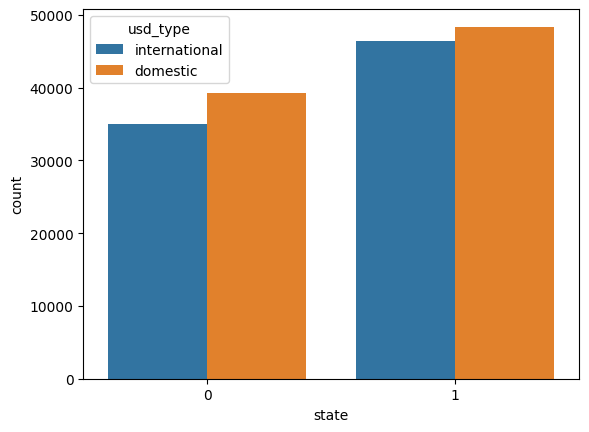

In [27]:
sns.countplot(data=data, x='state', hue='usd_type')

In [28]:
plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in time_df.columns.tolist():
    plt.subplot(5,2,i)
    sns.boxplot(data=time_df, x=name)
    i = i + 1

NameError: name 'time_df' is not defined

<Figure size 2000x3000 with 0 Axes>

In [ ]:
# KEEP ONLY SUCCESSFUL AND FAILED (otherwise comparing apples and pears (:  )

display(data.query('pledged >= goal and state == False').groupby('state').state.count())
display(data.query('pledged <= goal and spotlight == True').groupby('state').state.count())
display(data.groupby('state').state.count())
display(data.groupby('state').state.count())

In [ ]:
sns.countplot(data=data, x='state', hue='spotlight')

In [ ]:
data.query('state=="live"')['state'].count()